In [156]:
"""
2D Navier-Stokes Equation (vorticity-streamfunction formulation)
    Spatial: Hybrid Arakawa-Spectral
    Temporal: RK3
"""
import sys
import numpy as np
import scipy
from numba import njit, jit, float64, int64
import pyfftw

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib
import scipy.sparse
import numpy.linalg
from tqdm.notebook import tqdm
np.set_printoptions(threshold=sys.maxsize, linewidth=np.inf)

%matplotlib inline

matplotlib.rcParams['figure.dpi'] = 1200
matplotlib.rcParams['savefig.dpi'] = 1200
matplotlib.rcParams['contour.negative_linestyle'] = 'solid'


In [157]:
@njit(float64(float64[:, :]))
def rms(a):
    return np.sqrt(np.mean(a**2))


In [158]:
def BoundaryConditionPer(w):
    w[1:-1,-1] = w[1:-1,1]
    w[-1,1:-1] = w[1,1:-1]
    w[-1,-1] =   w[1,1]
    w[1:,0] =    w[1:,-2]
    w[0,1:] =    w[-2,1:]
    w[0,0] =     w[-2,-2]

In [159]:
def JacobianFromSpectral(wTilda,k2,dX,dY):
    sTilda = wTilda/k2
    w = np.zeros([i+2 for i in wTilda.shape])
    s = w*0
    w[1:-1,1:-1] = np.real(scipy.fft.ifft2(wTilda))
    BoundaryConditionPer(w)
    s[1:-1,1:-1] = np.real(scipy.fft.ifft2(sTilda))
    BoundaryConditionPer(s)

    result = s*0

    J1 = (
        (w[2:, 1:-1]-w[0:-2, 1:-1])*(s[1:-1, 2:]-s[1:-1, 0:-2]) -
        (w[1:-1, 2:]-w[1:-1, 0:-2])*(s[2:, 1:-1]-s[0:-2, 1:-1])
    )

    J2 = (
        w[2:, 1:-1]*(s[2:, 2:] - s[2:, :-2]) -
        w[:-2, 1:-1]*(s[:-2, 2:] - s[:-2, :-2]) -
        w[1:-1, 2:]*(s[2:, 2:] - s[:-2, 2:]) +
        w[1:-1, :-2]*(s[2:, :-2]-s[:-2, :-2])
    )

    J3 = (
        w[2:, 2:]*(s[1:-1, 2:] - s[2:, 1:-1]) -
        w[:-2, :-2]*(s[:-2, 1:-1] - s[1:-1, :-2]) -
        w[:-2, 2:]*(s[1:-1, 2:] - s[:-2, 1:-1]) +
        w[2:, :-2]*(s[2:, 1:-1] - s[1:-1, :-2])
    )

    result[1:-1, 1:-1] = (J1+J2+J3)/(12*dX*dY)

    return scipy.fft.fft2(result[1:-1,1:-1])


In [160]:
def PadZero32rule(a):
    Nx = a.shape[0]
    Ny = a.shape[1]

    Nx0, Nx1, Nx2, Nx3 = (*((np.arange(4)*Nx/2).astype(int)),)
    Ny0, Ny1, Ny2, Ny3 = (*((np.arange(4)*Ny/2).astype(int)),)
    Nx2 = Nx
    Ny2 = Ny

    b = np.zeros((Nx3,Ny3), dtype=a.dtype)
    b[Nx0:Nx1,Ny0:Ny1] = a[Nx0:Nx1,Ny0:Ny1]
    b[Nx0:Nx1,Ny2:Ny3] = a[Nx0:Nx1,Ny1:Ny2]
    b[Nx2:Nx3,Ny2:Ny3] = a[Nx1:Nx2,Ny1:Ny2]
    b[Nx2:Nx3,Ny0:Ny1] = a[Nx1:Nx2,Ny0:Ny1]

    return b

In [161]:
def DePadZero32rule(a):
    Nx = a.shape[0]
    Ny = a.shape[1]

    Nx0, Nx1, Nx2, Nx3 = (*((np.arange(4)*Nx/3).astype(int)),)
    Ny0, Ny1, Ny2, Ny3 = (*((np.arange(4)*Ny/3).astype(int)),)
    Nx3 = Nx
    Ny3 = Ny

    b = np.zeros((Nx2,Ny2), dtype=a.dtype)
    b[Nx0:Nx1,Ny0:Ny1] = a[Nx0:Nx1,Ny0:Ny1]
    b[Nx0:Nx1,Ny1:Ny2] = a[Nx0:Nx1,Ny2:Ny3]
    b[Nx1:Nx2,Ny1:Ny2] = a[Nx2:Nx3,Ny2:Ny3]
    b[Nx1:Nx2,Ny0:Ny1] = a[Nx2:Nx3,Ny0:Ny1]

    return b

In [162]:
def JacobianDiffSpectral(wTilda,k2,dX,dY, m,n):
    sTilda = wTilda/k2

    dwdxTilda_p = PadZero32rule(1j*m*wTilda)
    dwdyTilda_p = PadZero32rule(1j*n*wTilda)
    dsdxTilda_p = PadZero32rule(1j*m*sTilda)
    dsdyTilda_p = PadZero32rule(1j*n*sTilda)
    
    J = DePadZero32rule(scipy.fft.fft2(
        scipy.fft.ifft2(dsdyTilda_p)*scipy.fft.ifft2(dwdxTilda_p) - 
        scipy.fft.ifft2(dsdxTilda_p)*scipy.fft.ifft2(dwdyTilda_p)
    ))*(1.5)**2

    return J


In [163]:
def JacobianDiffSpectral23Rule(wTilda,k2,dX,dY, m,n):
    sTilda = wTilda/k2

    dwdxTilda_p = DePadZero32rule(1j*m*wTilda)
    dwdyTilda_p = DePadZero32rule(1j*n*wTilda)
    dsdxTilda_p = DePadZero32rule(1j*m*sTilda)
    dsdyTilda_p = DePadZero32rule(1j*n*sTilda)
    
    J = PadZero32rule(scipy.fft.fft2(
        scipy.fft.ifft2(dsdyTilda_p)*scipy.fft.ifft2(dwdxTilda_p) - 
        scipy.fft.ifft2(dsdxTilda_p)*scipy.fft.ifft2(dwdyTilda_p)
    ))*(2/3)**2

    return J


In [164]:
def PoissonFFTSpectral(fA, dX, dY, mA, nA, Nx, Ny):
    eps = 1e-10
    f = fA[:-1,:-1]
    m = np.roll(mA[:-1,:-1] - Nx/2, (int(Nx/2),int(Ny/2)), axis=(0,1))
    n = np.roll(nA[:-1,:-1] - Ny/2, (int(Nx/2),int(Ny/2)), axis=(0,1))
    fTilda = scipy.fft.fft2(f)
    u = fA*np.nan
    uTilda = -fTilda/((2*np.pi*m/(Nx*dX))**2+(2*np.pi*n/(Ny*dY))**2+eps)
    u[:-1,:-1] = np.real(scipy.fft.ifft2(uTilda))
    u[-1,:] = u[0,:]
    u[:,-1] = u[:,0]
    return u


In [165]:
def InitialConditionVortexMerger(x,y):
    xc1 = np.pi-np.pi/4.0 # horizontal location of left vortex
    yc1 = np.pi # vertical location of left vortex
    xc2 = np.pi+np.pi/4.0 # horizontal location of right vortex
    yc2 = np.pi # vertical location of right~vortex

    w = np.exp(-np.pi*((x-xc1)**2+(y-yc1)**2)) + np.exp(-np.pi*((x-xc2)**2+(y-yc2)**2))
    return w

In [166]:
def RK3NavierStokes(wTildaOrig, sTildaOrig, dX, dY, k2, m,n, Nx, Ny, dT, Re, BCFun):
    alpha1, alpha2, alpha3 = 8.0/15.0, 2.0/15.0, 1.0/3.0
    gamma1, gamma2, gamma3 = 8.0/15.0, 5.0/12.0, 3.0/4.0
    rho2, rho3 = -17.0/60.0, -5.0/12.0
    
    JTildaOriginal = JacobianDiffSpectral23Rule(wTildaOrig, k2, dX, dY,m,n)
    #JTildaOriginal = JacobianFromSpectral(wTildaOrig, k2, dX, dY)
    

    wTildaOne = (
        (1-0.5*alpha1*dT/Re*k2)*wTildaOrig - gamma1*dT*JTildaOriginal
    )/(1+0.5*alpha1*dT/Re*k2)
    JTildaOne = JacobianDiffSpectral23Rule(wTildaOne, k2, dX, dY,m,n)
    #JTildaOne = JacobianFromSpectral(wTildaOne, k2, dX, dY)

    wTildaTwo = (
        (1-0.5*alpha2*dT/Re*k2)*wTildaOne - dT*(gamma2*JTildaOne + rho2*JTildaOriginal)
    )/(1+0.5*alpha2*dT/Re*k2)
    JTildaTwo = JacobianDiffSpectral23Rule(wTildaTwo, k2, dX, dY,m,n)
    #JTildaTwo = JacobianFromSpectral(wTildaTwo, k2, dX, dY)

    wTildaNow = (
        (1-0.5*alpha3*dT/Re*k2)*wTildaTwo - dT*(gamma3*JTildaTwo + rho3*JTildaOne)
    )/(1+0.5*alpha3*dT/Re*k2)

    sTildaNow = wTildaNow/k2

    return wTildaNow, sTildaNow


In [167]:
xMin, xMax = 0.0, 2*np.pi
yMin, yMax = 0.0, 2*np.pi

tol = 1e-9
maxIter = 100000

numXCen = 192
numYCen = 192

xList, deltaX = np.linspace(xMin, xMax, numXCen+1, retstep=True)
yList, deltaY = np.linspace(yMin, yMax, numYCen+1, retstep=True)

xList = np.hstack((xList[0]-deltaX, xList))
yList = np.hstack((yList[0]-deltaY, yList))

numXGrid = xList.shape[0]
numYGrid = yList.shape[0]

xMat, yMat = np.meshgrid(xList, yList, indexing="ij")
mMat, nMat = np.meshgrid(np.arange(numXCen), np.arange(numYCen), indexing="ij")
m = np.roll(mMat - numXCen/2, (int(numXCen/2),int(numYCen/2)), axis=(0,1))
n = np.roll(nMat - numYCen/2, (int(numYCen/2),int(numYCen/2)), axis=(0,1))
k2 = m**2+n**2+10**-12

tStart = 0.0
tEnd = 20
deltaT = 1e-2
numStep = np.rint((tEnd-tStart)/deltaT).astype(int)

Re = 1000.0

wInitial = InitialConditionVortexMerger(xMat,yMat)
wTildaInitial = scipy.fft.fft2(wInitial[1:-1,1:-1])
sTildaInitial = wTildaInitial/k2


wTildaOriginal = wTildaInitial*1
sTildaOriginal = sTildaInitial*1

tNow = tStart

dwdt = np.zeros(numStep)
timeSeries = np.linspace(0, tEnd, numStep+1)


In [168]:
for iStep in tqdm(range(numStep)):
    tNow += deltaT
    wTildaOriginal, sTildaOriginal = RK3NavierStokes(
        wTildaOriginal, sTildaOriginal, deltaX, deltaY, k2, m, n, numXCen, numYCen, deltaT, Re, BoundaryConditionPer)

wOriginal = np.zeros([xList.shape[0],yList.shape[0]])
sOriginal = wOriginal*0
wOriginal[1:-1,1:-1] = np.real(scipy.fft.ifft2(wTildaOriginal))
sOriginal[1:-1,1:-1] = np.real(scipy.fft.ifft2(wTildaOriginal/k2))
sOriginal -= sOriginal[1,1]
BoundaryConditionPer(wOriginal)
BoundaryConditionPer(sOriginal)


  0%|          | 0/2000 [00:00<?, ?it/s]

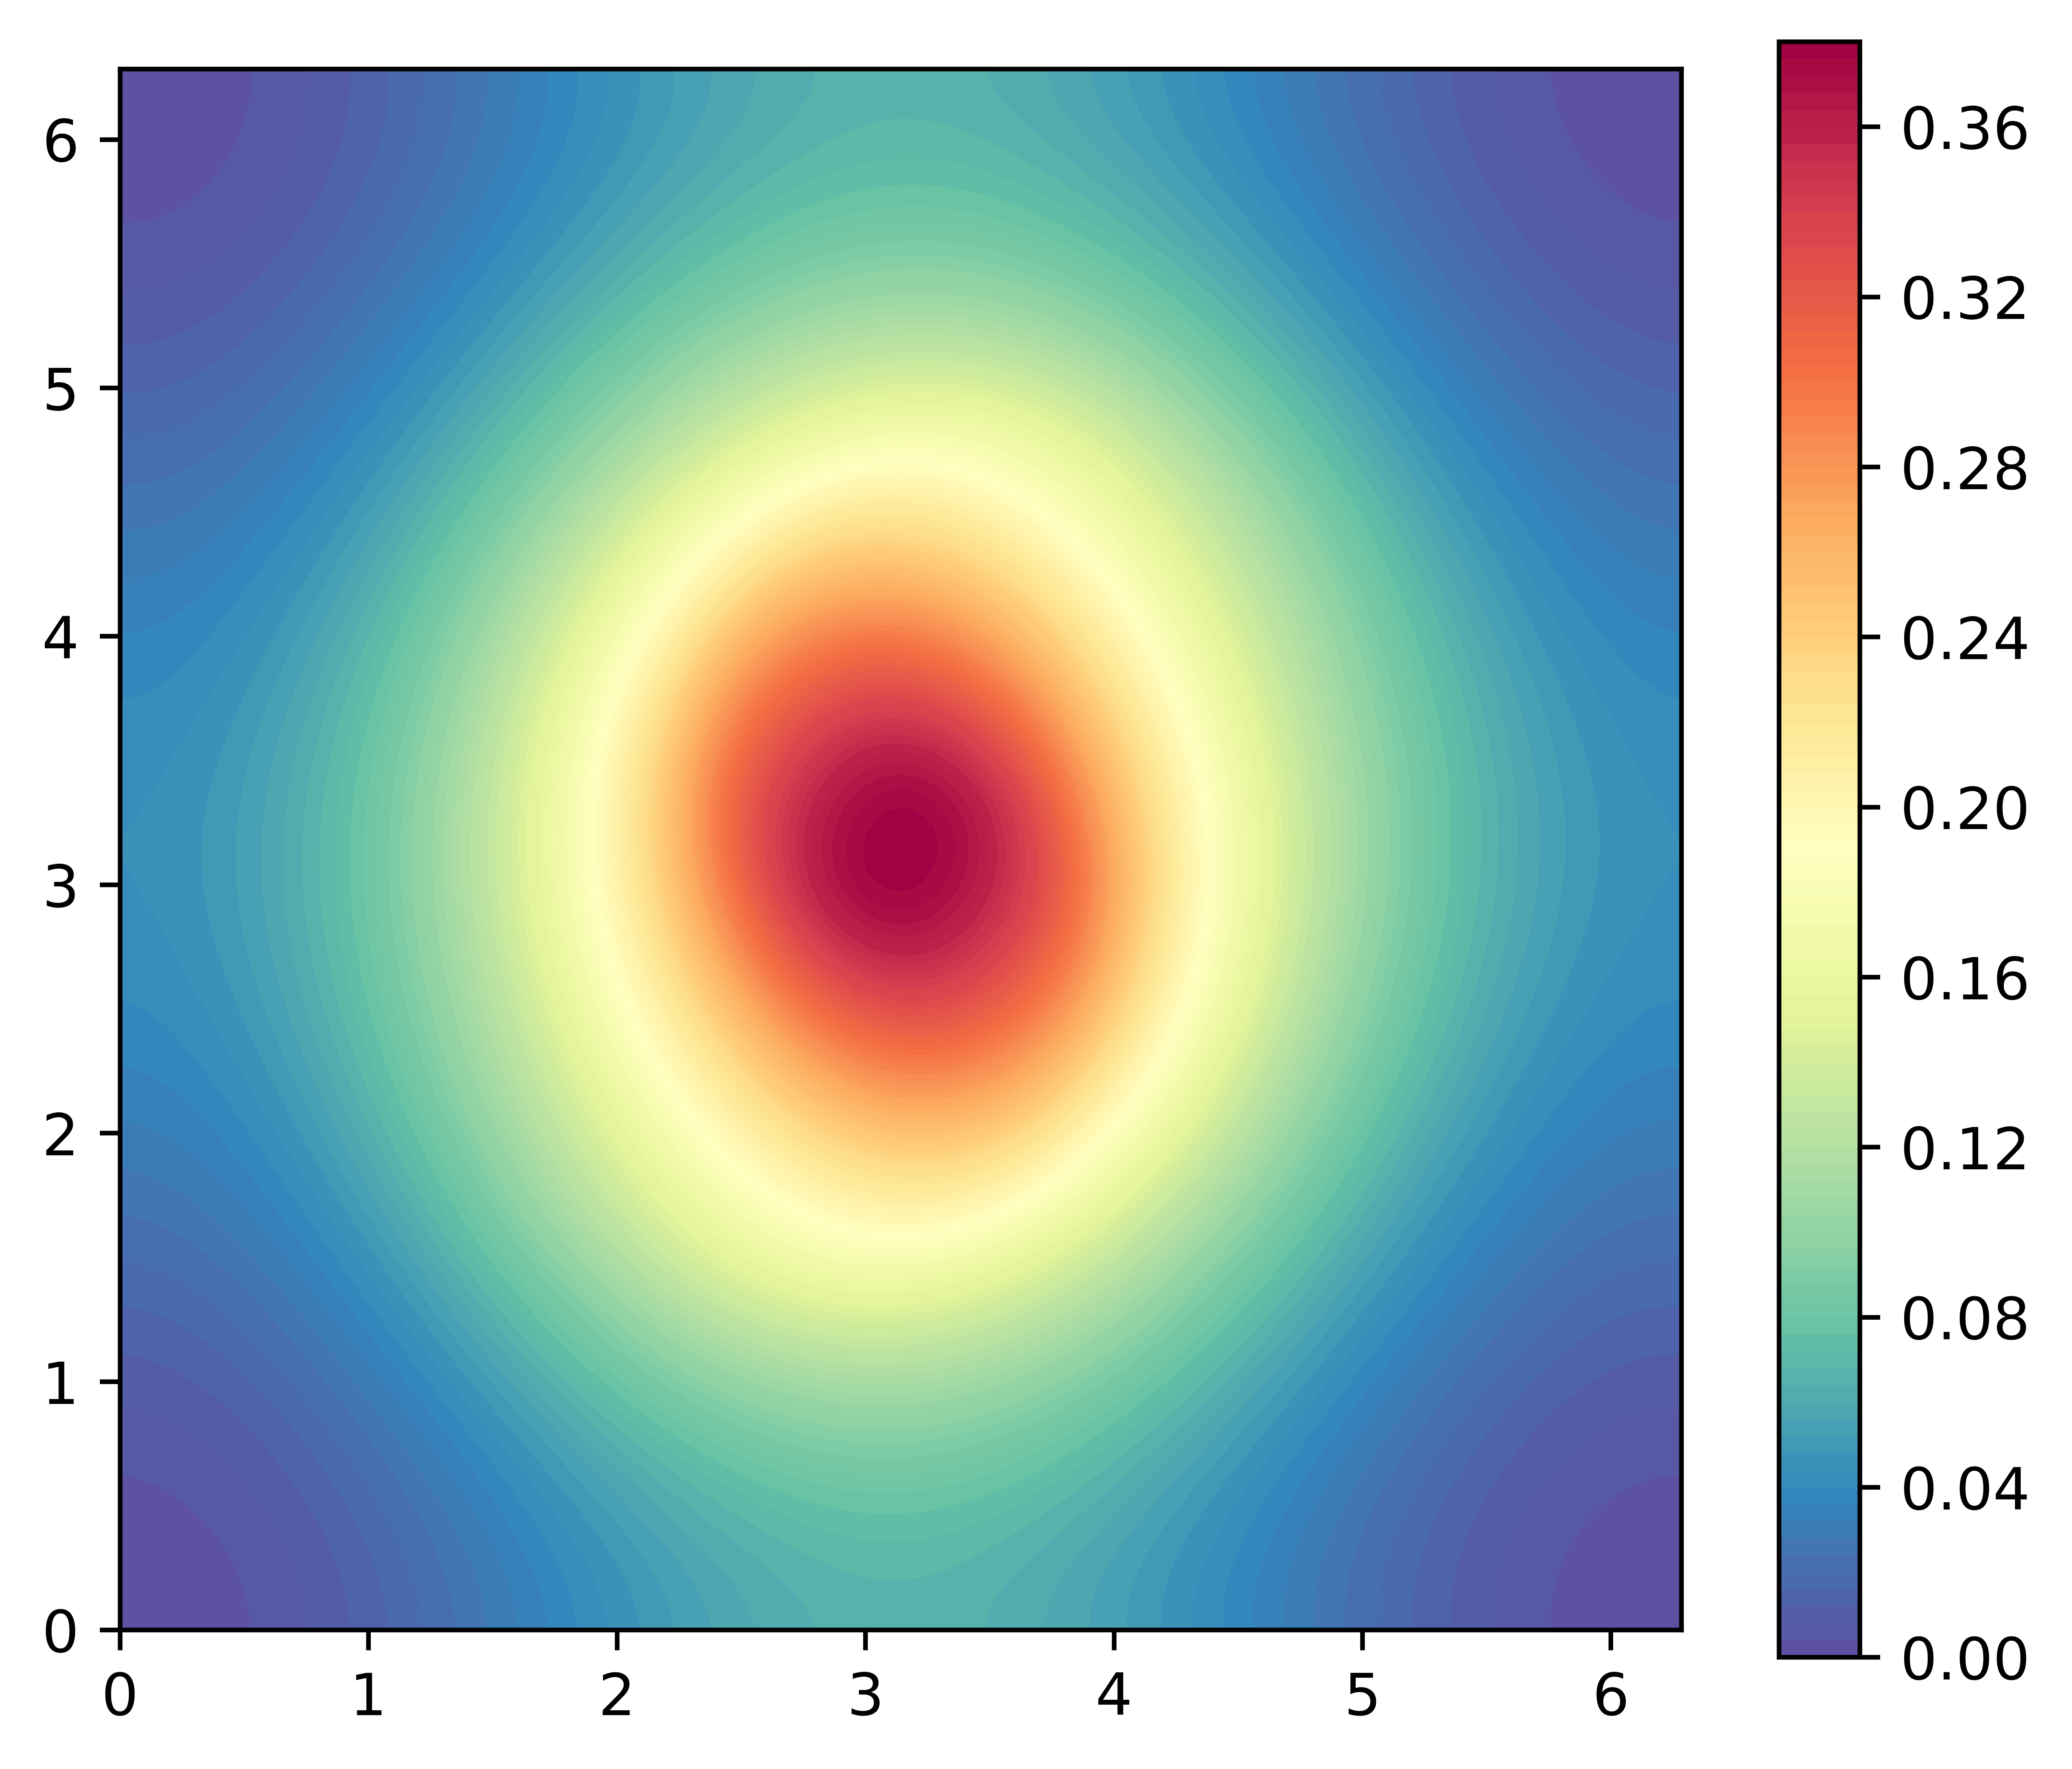

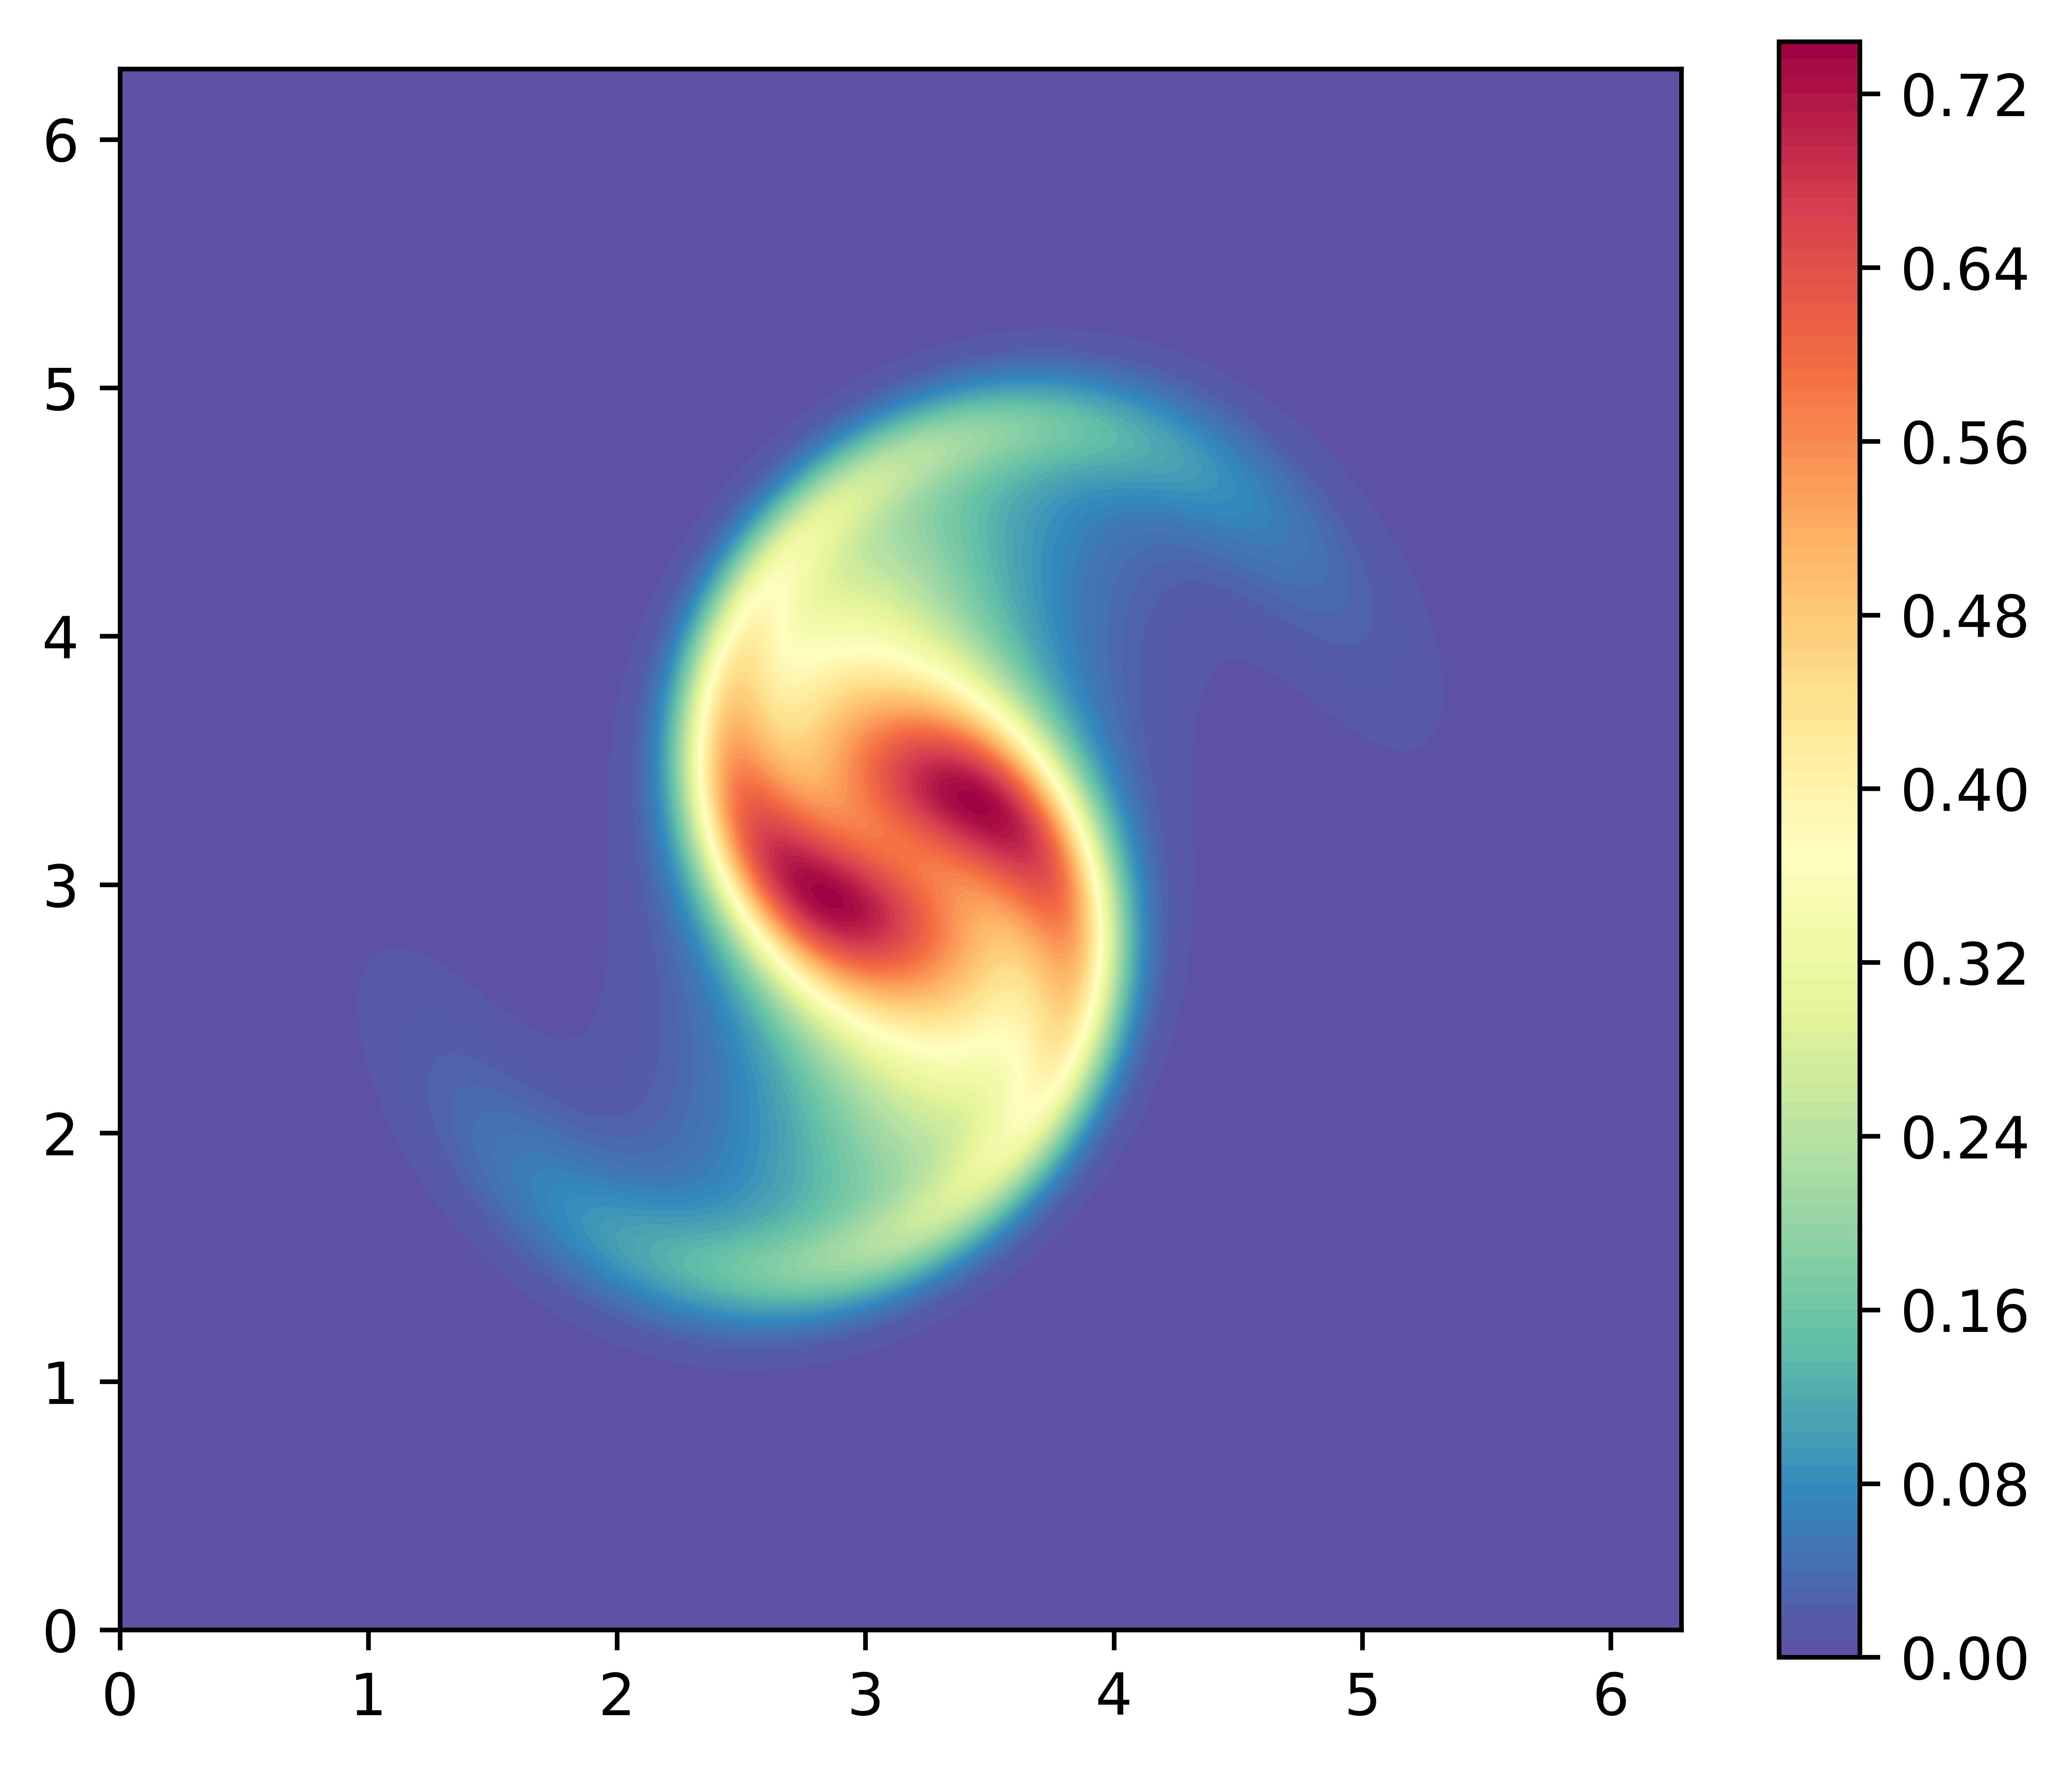

In [169]:
colormap = cm.get_cmap("Spectral_r")

fig, ax = plt.subplots(figsize=(6, 5))
a = ax.contourf(xMat, yMat, sOriginal, levels=100, cmap=colormap)
ax.set_xlim([0, 2*np.pi])
ax.set_ylim([0, 2*np.pi])
ax.set_aspect("equal")
cbar = fig.colorbar(a)

fig, ax = plt.subplots(figsize=(6, 5))
a = ax.contourf(xMat, yMat, wOriginal, levels=100, cmap=colormap)
ax.set_xlim([0, 2*np.pi])
ax.set_ylim([0, 2*np.pi])
ax.set_aspect("equal")
cbar = fig.colorbar(a)
